Flag used for either executing code mapping or loading the mapping pickle files

In [18]:
CREATE_OR_LOAD_MAPPING = 'create' # create or load
NUM_OF_PROCESSORS = 4

## Mapping discussed during the meeting

1. Take the string from the medqa answer.
2. Check if there is a corresponding string match in the umls csv for the disease.
3. If there is a match, take the CUI and check if there are documents with that CUI match

In [19]:
import json
import math
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import pandas as pd
import pickle
import re
# in order to ignore the UserWarning: THis pattern has match groups
import warnings
warnings.filterwarnings("ignore", 'This pattern has match groups')

from itertools import groupby
from nltk import word_tokenize
from tqdm import tqdm

In [20]:
umls_terms_path = '../data/umls_terms.csv'
findzebra_csv_path = '../data/findzebra.csv'
findzebra_json_path = '../data/findzebra.json'
medqa_questions_dev_path = '../data/medqa/questions/dev.jsonl'
medqa_questions_path = '../data/medqa/questions/US_qbank.jsonl'

# old
answer_findzebra_articles_map_pickle_path = 'answer_findzebra_articles_map.pickle'
failed_mapping_path = 'failed_mapping.pickle'

# new
answer_cui_articles_matching_path = 'answer_cui_articles_matching.pickle'
failed_cui_articles_matching_path = 'failed_cui_articles_matching.pickle'

In [54]:
def save_data(data, file_path):
    with open(file_path, 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_pickle(file_path):
    with open(file_path, 'rb') as handle:
        return pickle.load(handle)

### Get all medqa answers

In [53]:
medqa_all_questions = []

with open(medqa_questions_path, 'r') as file:
    for line in file:
        medqa_all_questions.append(json.loads(line))
        
medqa_all_answers = []
for x in tqdm([list(q['options'].values()) for q in medqa_all_questions]):
    medqa_all_answers.append(x)
    
medqa_all_answers = [item.lower() for sublist in medqa_all_answers for item in sublist]
print(f'Number of all MedQA answers: {len(medqa_all_answers)}')

medqa_all_unique_answers = list(set(medqa_all_answers))
print(f'Number of all *unique* MedQA answers: {len(medqa_all_unique_answers)}')

# save_data(medqa_all_unique_answers, 'medqa_all_unique_answers.pickle')
# medqa_all_unique_answers = load_pickle('medqa_all_unique_answers.pickle')

100%|██████████| 14369/14369 [00:00<00:00, 1415538.19it/s]

Number of all MedQA answers: 77227
Number of all *unique* MedQA answers: 46420


### Get the umls_terms data

In [22]:
umls_terms = pd.read_csv(umls_terms_path)

# lines 56-67 from the SemGroups_2018.txt
disorders_tui = {
    "T020": "Acquired Abnormality",
    "T190": "Anatomical Abnormality",
    "T049": "Cell or Molecular Dysfunction",
    "T019": "Congenital Abnormality",
    "T047": "Disease or Syndrome",
    "T050": "Experimental Model of Disease",
    "T033": "Finding",
    "T037": "Injury or Poisoning",
    "T048": "Mental or Behavioral Dysfunction",
    "T191": "Neoplastic Process",
    "T046": "Pathologic Function",
    "T184": "Sign or Symptom"
}

print(f'Number of records in umls_terms before TUI filtering: {umls_terms.shape[0]}')

# preserve only data related to the diseases' TUIs
umls_terms = umls_terms.loc[umls_terms['TUI'].isin(disorders_tui.keys())].reset_index(drop=True)
print(f'Number of records in umls_terms after TUI filtering: {umls_terms.shape[0]}')

# one row does not have a STR value, hence drop it
umls_terms = umls_terms.dropna(subset=['STR'])
umls_terms['STR'] = umls_terms['STR'].apply(lambda x: x.lower())

umls_cuis = umls_terms['CUI'].unique()

Number of records in umls_terms before TUI filtering: 8851980
Number of records in umls_terms after TUI filtering: 1775855


### Load findzebra dataset

In [23]:
def clean_html(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext

In [24]:
relevant_columns = {
    "title": 2,
    "raw_content": 3,
    "cui": 6,
    "classification_map": 7
}

# clearing html tags and removing trailing whitespaces
findzebra_df = pd.read_csv(findzebra_csv_path, header=None, usecols=relevant_columns.values())
findzebra_df.columns = relevant_columns.keys()    
    
print("=== stats===")
print(f"findzebra_df: # of rows: {findzebra_df.shape[0]}")

findzebra_df['raw_content'] = findzebra_df['raw_content'].apply(lambda x: clean_html(x))
findzebra_df['raw_content'] = findzebra_df['raw_content'].apply(lambda x: x.lower().replace('\n','').strip())

=== stats===
findzebra_df: # of rows: 30658


In [26]:
def map_findzebra_articles_to_medqa_answers(answer_options, mapping, failed_mapping):
    for answer_option in tqdm(answer_options):
        try:
            matching_umls = umls_terms.loc[umls_terms['STR'].str.contains(answer_option, na=False)]
            disease_cuis = matching_umls['CUI'].unique()
            if len(disease_cuis) > 0:
                matching_articles = findzebra_df.loc[findzebra_df['cui'].isin(disease_cuis)]

                if matching_articles.shape[0] > 0:
                    cui_aricle_id = {}
                    for i, match in matching_articles.iterrows():
                        cui_aricle_id[match['cui']] = match
                    mapping[answer_option] = cui_aricle_id
                else:
                    mapping[answer_option] = {}
            else:
                mapping[answer_option] = {}    
        except:
            failed_mapping.append(answer_option)

In [27]:
# returns dictionary where key is the answer option and value is tuple: (CUI: dataframe of matched articles)

def new_map_findzebra_articles_to_medqa_answers(answer_options, mapping, failed_mapping):
    for answer_option in tqdm(answer_options):
        try:
            mapping[answer_option] = []
            matching_umls = umls_terms.loc[umls_terms['STR'].str.contains(answer_option, na=False)]
            disease_cuis = matching_umls['CUI'].unique()
            if len(disease_cuis) > 0:
                matching_articles = findzebra_df.loc[findzebra_df['cui'].isin(disease_cuis)]

                if matching_articles.shape[0] > 0:
                    matched_cuis = matching_articles['cui'].unique()
                    cui_articles = []
                    
                    for matched_cui in matched_cuis:
                        matched_articles = findzebra_df.loc[findzebra_df['cui'] == matched_cui]
                        cui_articles.append((matched_cui, matched_articles))
                    
                    mapping[answer_option] += cui_articles
        except:
            failed_mapping.append(answer_option)

In [28]:
def chunks(data, number_of_processes):
    chunk_size = math.ceil(math.ceil(len(data) / number_of_processes))

    for i in range(0, len(data), chunk_size):
        yield data[i:i + chunk_size]

In [29]:
def multiprocess_mapping(method_used, num_of_processors, all_answers):
    manager = multiprocessing.Manager()
    all_results = manager.dict()
    all_fails = manager.list()
    jobs = []
    
    data = list(chunks(all_answers, num_of_processors))

    for i in range(num_of_processors):
        p = multiprocessing.Process(target=method_used, args=(data[i], all_results, all_fails))
        jobs.append(p)
        p.start()

    for proc in jobs:
        proc.join()
        
    return dict(all_results), list(all_fails)


In [40]:
a = load_pickle('0-34.pickle')
b = load_pickle('34-68.pickle')

x = load_pickle('lol_failed0-60.pickle')
y = load_pickle('lol_failed60-100.pickle')

answer_cui_articles_matching = dict(a)
answer_cui_articles_matching.update(b)

failed_cui_articles_matching = x + y

In [16]:
# # example of WIP with parts (done)

first_thresh = int(len(medqa_all_unique_answers) / 100 * 34)
second_thresh = int(len(medqa_all_unique_answers) / 50 * 34)

# answer_cui_articles_matching_one, failed_cui_articles_matching_one = multiprocess_mapping(
#     method_used=new_map_findzebra_articles_to_medqa_answers, 
#     num_of_processors=NUM_OF_PROCESSORS, 
#     all_answers=medqa_all_unique_answers[:first_thresh]
# )
# save_data(answer_cui_articles_matching_one, '0-34.pickle') 

# answer_cui_articles_matching_two, failed_cui_articles_matching_two = multiprocess_mapping(
#     method_used=new_map_findzebra_articles_to_medqa_answers, 
#     num_of_processors=NUM_OF_PROCESSORS, 
#     all_answers=medqa_all_unique_answers[first_thresh:second_thresh]
# )
# save_data(answer_cui_articles_matching_two, '34-68.pickle') 

answer_cui_articles_matching_three, failed_cui_articles_matching_three = multiprocess_mapping(
    method_used=new_map_findzebra_articles_to_medqa_answers, 
    num_of_processors=NUM_OF_PROCESSORS, 
    all_answers=medqa_all_unique_answers[second_thresh:]
)
save_data(answer_cui_articles_matching_three, '68-100.pickle') 

failed_cui_articles_matching = failed_cui_articles_matching_one + failed_cui_articles_matching_two + failed_cui_articles_matching_three
# save_data(answer_cui_articles_matching_two, 'lol2.pickle') # 675MB: 

 87%|████████▋ | 3215/3714 [46:55<07:16,  1.14it/s]Process Process-12:

Process Process-13:
 87%|████████▋ | 3221/3714 [46:55<07:10,  1.14it/s]
Process Process-14:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "<ipython-input-12-e301e0f2826c>", line 6, in new_map_findzebra_articles_to_medqa_answers
    mapping[answer_option] = []
  File "<string>", line 2, in __setitem__
  File "<ipython-input-12-e301e0f2826c>", line 6, in new_map_findzebra_articles_to_medqa_answers
    mapping[answer_option] = []
  File "<ipython-input-12-e301e0f2826c>", line 20, in new_map_findzebra_articles_to_medqa_answers
    mapping[answer_option] += cui_articles
  File "/home/gustaw/anaconda3/lib/python3.8/multiprocessing/managers.py", line 835, in _callmethod
    kind, result = conn.recv()
  File "<string>", line 2, in __setitem__
  File "/home/gustaw/anaconda3/lib/python3.8/multiprocessing/connection.py", line 250, in recv
    buf = self._recv_b

BrokenPipeError: [Errno 32] Broken pipe


ConnectionRefusedError: [Errno 111] Connection refused

In [7]:
# a = load_pickle('lol0-10.pickle')
# b = load_pickle('lol10-30.pickle')
# c = load_pickle('lol30-60.pickle')
# d = load_pickle('lol60-80.pickle')
# e = load_pickle('lol80-100.pickle')

# total_len = len(a) + len(b) + len(c) + len(d) + len(e)
# print(total_len)

In [116]:
total_len = len(a) + len(b) + len(c) + len(d) + len(e)
print(total_len)

46420


In [117]:
print(len(f.keys()))

35331


In [28]:
# # Program to check the list contains any elements of another list

# # List1
# List1 = ['python' ,  'javascript', 'csharp', 'go', 'c', 'c++']
 
# # List2
# List2 = ['csharp1' , 'go', 'python']

# check =  any(item in a.keys() for item in e.keys())
 
# if check is True:
#     print("The list {} contains all elements of the list {}".format(List1, List2))    
# else :
#     print("No, List1 doesn't have all elements of the List2.")

### Creating mapping and saving to pickle file

In [16]:
if CREATE_OR_LOAD_MAPPING == 'create':
    answer_findzebra_articles_map, failed_mapping = multiprocess_mapping(new_map_findzebra_articles_to_medqa_answers, NUM_OF_PROCESSORS, medqa_all_unique_answers)
    save_data(answer_cui_articles_matching, answer_cui_articles_matching_path)
    save_data(failed_cui_articles_matching, failed_cui_articles_matching_path)

TypeError: multiprocess_mapping() missing 1 required positional argument: 'all_answers'

In [17]:
# new_answer_cui_articles_matching = {}
# new_failed_matching = []
# # more than 1 CUI, more than 1 article per CUI
# example_index = medqa_all_unique_answers.index('esophageal atresia')

# new_map_findzebra_articles_to_medqa_answers([medqa_all_unique_answers[example_index]], new_answer_cui_articles_matching, new_failed_matching)

# new_answer_findzebra_articles_map, failed_mapping = multiprocess_mapping(new_map_findzebra_articles_to_medqa_answers,2, medqa_all_unique_answers[:10])
# save_data(new_answer_findzebra_articles_map, new_answer_findzebra_articles_map_pickle_path)
# save_data(new_failed_mapping, new_failed_mapping_path)

# for cui in x_results['esophageal atresia']:
#     print(f'cui={cui[0]}')
#     print(f'\tNumber of articles: {cui[1].shape[0]}')
    


### Loading mapping from pickle files

In [31]:
if CREATE_OR_LOAD_MAPPING == 'load':
    answer_cui_articles_matching = load_pickle(answer_cui_articles_matching_path)
    failed_cui_articles_matching = load_pickle(failed_cui_articles_matching_path)

In [41]:
print(f'Number of all unique medqa answers: {len(medqa_all_unique_answers)}')
print(f'Number of mapped answers : {len(answer_cui_articles_matching)}')

Number of all unique medqa answers: 46420
Number of mapped answers : 31565


In [42]:
not_mapped_answers = [x for x in ({key: value for key, value in answer_cui_articles_matching.items() if not value})]
mapped_answers_cui = [{key: value} for key, value in answer_cui_articles_matching.items() if value]

In [58]:
[x for x in mapped_answers_cui]

KeyError: 0

In [43]:
print(f'Number of mapped answers: {len(mapped_answers_cui)}')
print(f'Number of not mapped answers: {len(not_mapped_answers)}')

matched_percentage_of_mapped_answers = 100 * len(mapped_answers_cui) / len(answer_cui_articles_matching)
matched_percentage_of_all_answers = 100 * len(mapped_answers_cui) / (len(answer_cui_articles_matching) + len(failed_cui_articles_matching))

print(f'Percentage of mapped unique answers of successful mapping: {matched_percentage_of_mapped_answers}%')
print(f'Total percentage of mapped unique answers: {matched_percentage_of_all_answers}%')

Number of mapped answers: 3737
Number of not mapped answers: 27828
Percentage of mapped unique answers of successful mapping: 11.839062252494852%
Total percentage of mapped unique answers: 11.833064184161362%


In [44]:
num_of_mapped_cuis_per_answer = []
num_of_mapped_articles_per_answer = []

for key in mapped_answers_cui:
    answer = next(iter(key.keys()))
    cui_articles_list = next(iter(key.values()))
    
    num_of_mapped_cuis_per_answer.append(len(cui_articles_list))
    
    num_of_articles = 0
    for (cui, articles) in cui_articles_list:
        num_of_articles += articles.shape[0]
        
    num_of_mapped_articles_per_answer.append(num_of_articles)

In [45]:
bins_0_5 = list(range(0, 6, 1))
bins_6_24 = list(range(6, 25, 1))
bins_25_49 = list(range(25, 50, 1))
bins_50_100 = list(range(50, 100, 2))

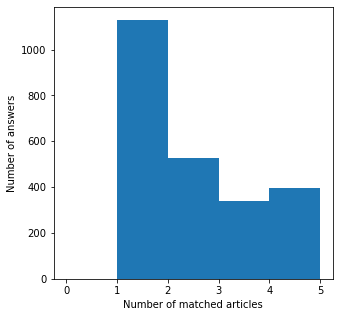

In [46]:
plt.figure(figsize=(5,5))
plt.hist(num_of_mapped_articles_per_answer, bins=bins_0_5) 
plt.xlabel('Number of matched articles')
plt.ylabel('Number of answers');

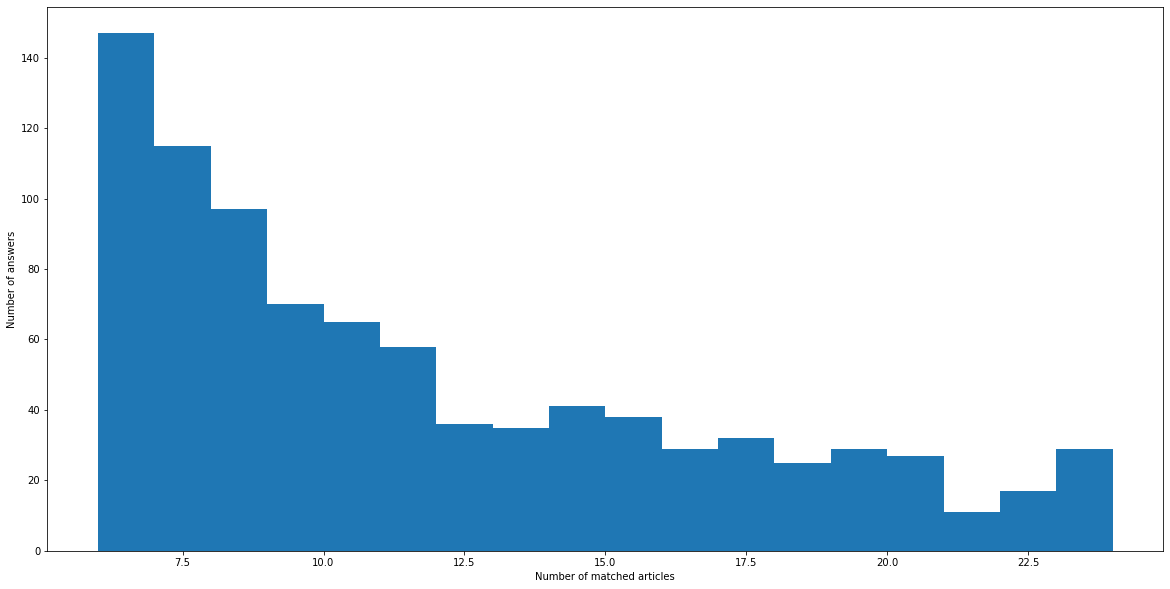

In [47]:
plt.figure(figsize=(20,10))
plt.hist(num_of_mapped_articles_per_answer, bins=bins_6_24) 
plt.xlabel('Number of matched articles')
plt.ylabel('Number of answers');

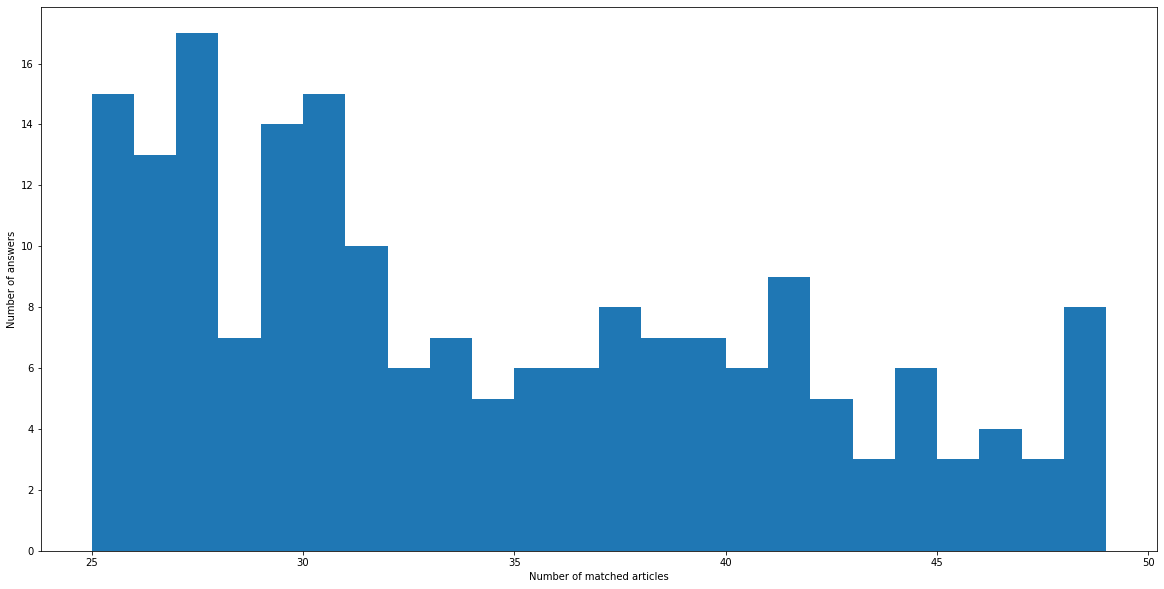

In [48]:
plt.figure(figsize=(20,10))
plt.hist(num_of_mapped_articles_per_answer, bins=bins_25_49) 
plt.xlabel('Number of matched articles')
plt.ylabel('Number of answers');

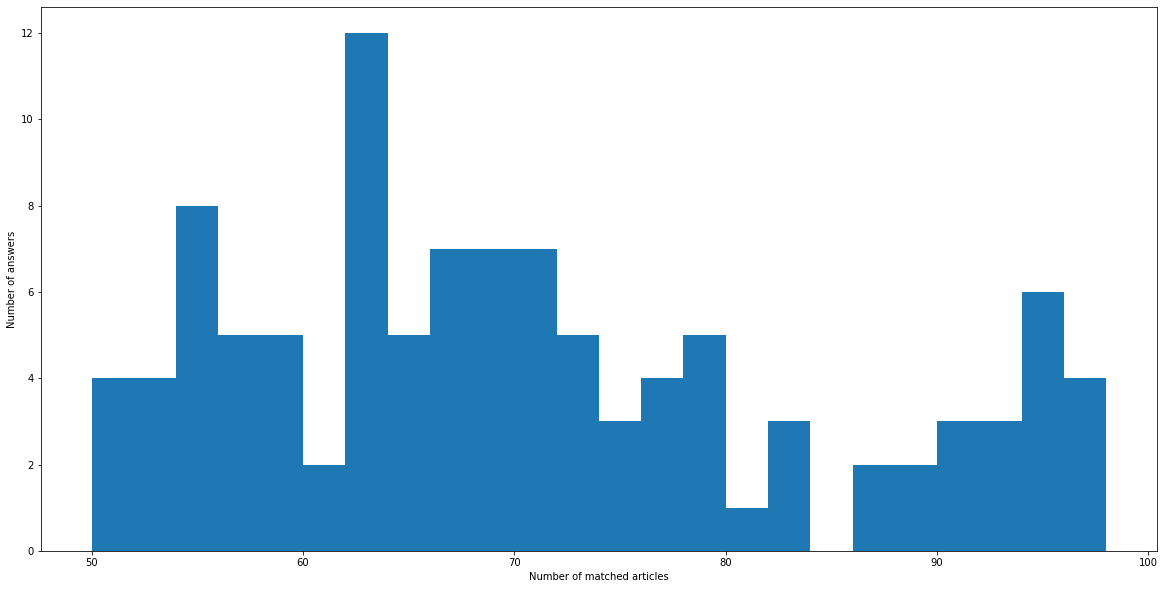

In [49]:
plt.figure(figsize=(20,10))
plt.hist(num_of_mapped_articles_per_answer, bins=bins_50_100) 
plt.xlabel('Number of matched articles')
plt.ylabel('Number of answers');

In [50]:
num_of_cuis_frequency = {key:len(list(group)) for key, group in groupby(np.sort(num_of_mapped_cuis_per_answer))}
num_of_cuis_frequency

{1: 1847,
 2: 555,
 3: 278,
 4: 166,
 5: 121,
 6: 101,
 7: 59,
 8: 57,
 9: 35,
 10: 41,
 11: 36,
 12: 25,
 13: 19,
 14: 25,
 15: 18,
 16: 17,
 17: 16,
 18: 14,
 19: 15,
 20: 13,
 21: 9,
 22: 5,
 23: 7,
 24: 3,
 25: 9,
 26: 8,
 27: 11,
 28: 8,
 29: 5,
 30: 6,
 31: 4,
 32: 4,
 33: 7,
 34: 6,
 35: 6,
 36: 5,
 37: 1,
 38: 6,
 39: 6,
 40: 4,
 41: 3,
 42: 2,
 43: 1,
 44: 3,
 45: 2,
 46: 1,
 47: 4,
 48: 1,
 49: 4,
 50: 2,
 51: 3,
 52: 3,
 53: 3,
 54: 2,
 56: 2,
 58: 1,
 59: 2,
 61: 2,
 63: 2,
 64: 1,
 65: 2,
 66: 3,
 69: 2,
 70: 1,
 72: 2,
 73: 1,
 74: 1,
 76: 2,
 77: 1,
 79: 1,
 81: 4,
 85: 1,
 86: 1,
 87: 2,
 88: 3,
 90: 1,
 91: 1,
 92: 1,
 93: 2,
 94: 2,
 96: 4,
 98: 2,
 99: 1,
 104: 1,
 106: 1,
 107: 2,
 108: 1,
 110: 2,
 112: 1,
 114: 1,
 116: 1,
 118: 2,
 120: 1,
 123: 1,
 124: 1,
 127: 1,
 129: 1,
 130: 1,
 131: 1,
 132: 1,
 133: 2,
 135: 1,
 139: 2,
 144: 1,
 147: 1,
 169: 1,
 176: 1,
 180: 1,
 184: 1,
 201: 1,
 209: 1,
 215: 1,
 225: 1,
 229: 1,
 236: 1,
 244: 1,
 260: 1,
 277: 1,
 2

In [51]:
num_of_articles_and_frequency = {key:len(list(group)) for key, group in groupby(np.sort(num_of_mapped_articles_per_answer))}
num_of_articles_and_frequency

{1: 1129,
 2: 526,
 3: 340,
 4: 205,
 5: 192,
 6: 147,
 7: 115,
 8: 97,
 9: 70,
 10: 65,
 11: 58,
 12: 36,
 13: 35,
 14: 41,
 15: 38,
 16: 29,
 17: 32,
 18: 25,
 19: 29,
 20: 27,
 21: 11,
 22: 17,
 23: 17,
 24: 12,
 25: 15,
 26: 13,
 27: 17,
 28: 7,
 29: 14,
 30: 15,
 31: 10,
 32: 6,
 33: 7,
 34: 5,
 35: 6,
 36: 6,
 37: 8,
 38: 7,
 39: 7,
 40: 6,
 41: 9,
 42: 5,
 43: 3,
 44: 6,
 45: 3,
 46: 4,
 47: 3,
 48: 5,
 49: 3,
 51: 4,
 52: 2,
 53: 2,
 54: 3,
 55: 5,
 56: 3,
 57: 2,
 58: 3,
 59: 2,
 60: 1,
 61: 1,
 62: 5,
 63: 7,
 64: 3,
 65: 2,
 66: 4,
 67: 3,
 68: 2,
 69: 5,
 70: 2,
 71: 5,
 72: 1,
 73: 4,
 74: 1,
 75: 2,
 76: 2,
 77: 2,
 78: 4,
 79: 1,
 80: 1,
 82: 2,
 83: 1,
 86: 1,
 87: 1,
 88: 2,
 90: 2,
 91: 1,
 92: 2,
 93: 1,
 94: 6,
 97: 2,
 98: 2,
 99: 3,
 100: 5,
 101: 1,
 102: 1,
 103: 2,
 104: 2,
 105: 1,
 110: 1,
 111: 2,
 112: 1,
 113: 2,
 116: 1,
 117: 1,
 118: 1,
 120: 3,
 122: 1,
 125: 2,
 127: 2,
 131: 1,
 133: 2,
 135: 1,
 136: 1,
 137: 1,
 140: 2,
 141: 2,
 142: 1,
 144: 1,
 

### Exampe of displaying the mapped articles

In [106]:
example = mapped_answers_cui[0]
medqa_answer = next(iter(example.keys()))
mappings = next(iter(example.values()))

print(f'MedQA answer: {medqa_answer}')
print(f'Number of matched CUIs: {len(mappings)}')
print(f'Second matched CUI: {mappings[1][0]}')
example_article_content = mappings[1][1].iloc[1]['raw_content']
print(f'Second matched CUI\'s second article\'s content: {example_article_content}')

MedQA answer: hereditary angioedema
Number of matched CUIs: 6
Second matched CUI: C1862892
Second matched CUI's second article's content: hereditary angioedema is a disorder characterized by recurrent episodes of severe swelling (angioedema). the most common areas of the body to develop swelling are the limbs, face, intestinal tract, and airway. minor trauma or stress may trigger an attack, but swelling often occurs without a known trigger. episodes involving the intestinal tract cause severe abdominal pain, nausea, and vomiting. swelling in the airway can restrict breathing and lead to life-threatening obstruction of the airway. about one-third of people with this condition develop a non-itchy rash called erythema marginatum during an attack.symptoms of hereditary angioedema typically begin in childhood and worsen during puberty.  on average, untreated individuals have an attack every 1 to 2 weeks, and most episodes last for about 3 to 4 days. the frequency and duration of attacks var

# Previous approach (less valid, nothing interesting)

## 1. Filter the disease-related UMLS terms based on TUI

In [ ]:
# umls_terms = pd.read_csv(umls_terms_path)

# # lines 56-67 from the SemGroups_2018.txt
# disorders_tui = {
#     "T020": "Acquired Abnormality",
#     "T190": "Anatomical Abnormality",
#     "T049": "Cell or Molecular Dysfunction",
#     "T019": "Congenital Abnormality",
#     "T047": "Disease or Syndrome",
#     "T050": "Experimental Model of Disease",
#     "T033": "Finding",
#     "T037": "Injury or Poisoning",
#     "T048": "Mental or Behavioral Dysfunction",
#     "T191": "Neoplastic Process",
#     "T046": "Pathologic Function",
#     "T184": "Sign or Symptom"
# }

# print(f'Number of records in umls_terms before TUI filtering: {umls_terms.shape[0]}')

# # preserve only data related to the diseases' TUIs
# umls_terms = umls_terms.loc[umls_terms['TUI'].isin(disorders_tui.keys())].reset_index(drop=True)
# # umls_terms.loc[umls_terms['STR'].str.contains('Chlamydia t', na=False)]

# print(f'Number of records in umls_terms after TUI filtering: {umls_terms.shape[0]}')

In [ ]:
# umls_cuis = umls_terms['CUI'].unique()

## 2. Filter findzebra dataset to contain only values with CUI matching the filtered UMLS terms

In [ ]:
# findzebra_df = pd.DataFrame()

# relevant_columns = {
#     "title": 2,
#     "raw_content": 3,
#     "cui": 6,
#     "classification_map": 7
# }
# no_cui_counter = 0
# original_findzebra_df_rows = 0
# for chunk in pd.read_csv(findzebra_csv_path, chunksize=1000, header=None, usecols=relevant_columns.values()):
#     # select only rows with value of CUI present in the umls_cuis
#     having_cui = chunk.loc[chunk[relevant_columns['cui']].isin(umls_cuis)]
#     findzebra_df = findzebra_df.append(having_cui)
#     # count number of rows without any cui value
#     no_cui_counter += chunk[relevant_columns['cui']].isnull().sum()
#     original_findzebra_df_rows += chunk.shape[0]

# findzebra_df.columns = relevant_columns.keys()    
    
# print("===findzebra_df stats===")
# print(f"\t\t# of rows: {findzebra_df.shape[0]}")
# print(f"\t\t# of rows not included as the original row did not contain CUI: {no_cui_counter} ({100 * no_cui_counter / original_findzebra_df_rows}%)")

In [ ]:
# # clearing html tags and removing trailing whitespaces

# def clean_html(raw_html):
#     cleanr = re.compile('<.*?>')
#     cleantext = re.sub(cleanr, '', raw_html)
#     return cleantext

# findzebra_df['raw_content'] = findzebra_df['raw_content'].apply(lambda x: clean_html(x))
# findzebra_df['raw_content'] = findzebra_df['raw_content'].apply(lambda x: x.lower().replace('\n','').strip())

In [ ]:
# import numpy as np
# import string

In [ ]:
# import nltk 
# from nltk.corpus import stopwords 
# stop_words = stopwords.words('english')
# custom_string_punctuation = string.punctuation.replace('-','').replace('/','')
# punctuation = str.maketrans('', '', custom_string_punctuation)

## 3. Analysis of MedQA answers coverage in the filtered findzebra dataset

In [ ]:
# len(medqa_dev_all_questions) * 5

In [ ]:
# medqa_dev_all_questions = []

# with open(medqa_questions_dev_path, 'r') as file:
#     for line in file:
#         medqa_dev_all_questions.append(json.loads(line))
        
# all_answers = []
# for x in tqdm([list(q['options'].values()) for q in medqa_dev_questions]):
#     all_answers.append(x)
# all_answers = [item.lower() for sublist in all_answers for item in sublist]

In [ ]:
# def check_answers_coverage(answer, evidence_df):
#     answer_option_tokens = [x.lower() for x in word_tokenize(answer) if x not in stop_words and x not in custom_string_punctuation]
#     highest_coverage = 0
    
#     for idx, row in evidence_df.iterrows():
#         title = row[0]
#         content = row[1]
        
#         coverage_counter = 0
#         for token in answer_option_tokens:
#             if token in content:
#                 coverage_counter += 1
#         if coverage_counter > highest_coverage:
#             highest_coverage = coverage_counter
            
#     return highest_coverage / len(answer_option_tokens)

In [ ]:
# answer_coverage = {}
# for answer in tqdm(all_answers):
#     answer_coverage[answer] = check_answers_coverage(answer, findzebra_df)

In [ ]:
# len(answer_coverage)

In [ ]:
# answer_coverage

In [ ]:
# len([x for x in answer_coverage.values() if x == 0])

In [ ]:
# import matplotlib.pyplot as plt

# plt.hist(answer_coverage.values(), bins=10)  # density=False would make counts
# plt.ylabel('Number of answers')
# plt.xlabel('Coverage');

In [ ]:
# 'i' in stop_words

In [ ]:
# def check_answers_coverage(question_data, evidence_df):
#     question = question_data['question']
#     answer_options = question_data['options'].values()
    
#     coverage = {}
#     for answer_option in answer_options:
#         if answer_option not in coverage.keys():
#             answer_option_tokens = [x.lower() for x in word_tokenize(answer_option) if x not in stop_words and x not in custom_string_punctuation]

#             coverage_counter = 0
#             print(answer_option_tokens)
#             for token in answer_option_tokens:
#                 print(len(evidence_df.loc[evidence_df['raw_content'].str.contains(token)]))
#                 if len(evidence_df.loc[evidence_df['raw_content'].str.contains(token)]) > 0:
#                     coverage_counter+=1

#             coverage[answer_option] = coverage_counter / len(answer_option_tokens)
    
#     return coverage

In [ ]:
# i = 0
# for ind, x in findzebra_df.iterrows():
#     print(x)
#     print('\n\n\n\n')
#     i += 1
    
#     if i == 3:
#         break

In [ ]:
# for z in medqa_dev_all_questions[16]['options'].values():
#     y = [x.lower() for x in word_tokenize(z) if x not in stop_words]

In [ ]:
# medqa_dev_all_questions[16]

In [ ]:
# medqa_covered_questions = []
# medqa_covered_answers = []
# coverage = {}
# for question in tqdm([medqa_dev_all_questions[16]]):
#     res = check_answers_coverage(question, findzebra_df)
#     coverage.update(res)


In [ ]:
# coverage